# 📑 Findings and Interpretations

---

## Finding 1: Dataset Composition
- **Observation:** 8,790 training videos and 1 test video. Majority (60.5%) from `MABe22_keypoints`, followed by `MABe22_movies` (29.6%).  
- **Interpretation:** The dataset is heavily skewed towards a few sources, which may bias models to learn lab-specific behaviors rather than general patterns.

---

## Finding 2: Technical Diversity
- **Observation:**  
  - Frame rates range from 10–120 FPS (median 30).  
  - Video durations vary widely (19–19,801s).  
  - 89 unique resolution combinations, with no single dominant standard.  
- **Interpretation:** High variability in video specs could cause inconsistencies in feature extraction. Normalization or resampling strategies are required.

---

## Finding 3: Arena Configurations
- **Observation:**  
  - Square arenas dominate (90.6%).  
  - Minority setups include rectangular, split-rectangular, and circular arenas.  
- **Interpretation:** Models may overfit to square setups. Special handling may be required for rare arena types to ensure generalization.

---

## Finding 4: Mouse Demographics
- **Observation:**  
  - 90.7% of videos have no mice metadata.  
  - Most common strain: C57Bl/6J.  
  - Sex distribution: overwhelmingly male (98.6%).  
- **Interpretation:** Severe metadata imbalance limits demographic-driven analysis. Gender/strain-related behavior patterns may not be generalizable.

---

## Finding 5: Tracking Data Quality
- **Observation:**  
  - High-velocity anomalies present across all labs (e.g., CRIM13: 2806 events).  
  - Test video (`AdaptableSnail`) tracking incomplete (82.2% completeness).  
- **Interpretation:** Tracking errors may corrupt downstream behavior inference. Test set quality issues could introduce evaluation bias.

---

## Finding 6: Annotation Characteristics
- **Observation:**  
  - Each lab defines 3–7 behaviors (11 total unique).  
  - CRIM13 annotations include 7 behaviors; others fewer (3 each).  
  - Strong skew: `sniff` and variants dominate across labs.  
- **Interpretation:** Behavior diversity is lab-specific. No universal annotation set exists, complicating cross-lab generalization.

---

## Finding 7: Annotation Durations
- **Observation:**  
  - Global median = 24 frames (~1s at 30 FPS).  
  - Short behaviors (<10 frames): 23%.  
  - Long behaviors (>52 frames): 24.7%.  
- **Interpretation:** Class imbalance exists between fleeting vs. sustained behaviors. Models must handle temporal extremes carefully.

---

## Finding 8: Annotation Quality Issues
- **Observation:**  
  - Temporal overlaps: up to 80.2% in CRIM13.  
  - Invalid frame ranges and ID mismatches.  
- **Interpretation:** Annotation errors may mislead training. Preprocessing/cleaning needed to avoid noisy supervision.

---

## Finding 9: Metadata Quality Issues
- **Observation:**  
  - Extremely high missingness in `mouse_id` fields (90–100%).  
  - `behaviors_labeled` missing in 90.2% of videos.  
- **Interpretation:** Metadata cannot be relied upon as strong supervision signals. Models must work primarily from video + tracking data.

---

## Finding 10: Cross-Laboratory Patterns
- **Observation:**  
  - Public datasets: shorter videos, fewer resolution variants.  
  - Anonymous labs: longer videos, more heterogeneous setups.  
  - Resident-intruder setups common across 11 labs.  
- **Interpretation:** Lab origin influences recording conditions and behavior types. Domain adaptation is crucial.

---

## Finding 11: Tracking Methodologies
- **Observation:**  
  - 90% tracked with custom HRNet.  
  - Minority use MARS, DeepLabCut, SLEAP.  
- **Interpretation:** Inconsistencies in tracking pipelines may produce systematic differences in data quality across labs.

---

## Finding 12: Strain Preferences
- **Observation:**  
  - C57Bl/6J is the dominant strain (used by 16 labs).  
  - Others rarely represented (C57Bl/6N, CD-1, hybrid).  
- **Interpretation:** Findings may overrepresent behavior typical of C57Bl/6J mice, limiting external validity across strains.

---


In [1]:
#!/usr/bin/env python3
"""
MABe Challenge - Social Action Recognition in Mice
Comprehensive Exploratory Data Analysis
Prepared by: NeurIPS Researcher, Anthropic Research Team
Target: Leadership Review (Demis Hassabis equivalent)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import os
from pathlib import Path
import glob
from collections import Counter, defaultdict
from scipy import stats
from scipy.spatial.distance import pdist, squareform
import json
from datetime import datetime

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

class MABeEDAAnalyzer:
    """Comprehensive EDA analyzer for MABe Challenge dataset"""
    
    def __init__(self):
        self.train_df = None
        self.test_df = None
        self.sample_submission = None
        self.tracking_data = {}
        self.annotation_data = {}
        self.analysis_results = {}
        
        print("="*80)
        print("MABe Challenge - Mouse Social Behavior Recognition")
        print("Comprehensive Exploratory Data Analysis")
        print("="*80)
        print(f"Analysis initiated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print()
    
    def load_data(self):
        """Load all available data files"""
        print("📂 LOADING DATASET...")
        print("-" * 40)
        
        try:
            # Load metadata
            if os.path.exists('/kaggle/input/MABe-mouse-behavior-detection/train.csv'):
                self.train_df = pd.read_csv('/kaggle/input/MABe-mouse-behavior-detection/train.csv')
                print(f"✅ Train metadata loaded: {self.train_df.shape}")
            else:
                print("⚠️  train.csv not found - generating representative data")
                self.train_df = self._generate_representative_metadata('train')
            
            if os.path.exists('/kaggle/input/MABe-mouse-behavior-detection/test.csv'):
                self.test_df = pd.read_csv('/kaggle/input/MABe-mouse-behavior-detection/test.csv')
                print(f"✅ Test metadata loaded: {self.test_df.shape}")
            else:
                print("⚠️  test.csv not found - generating representative data")
                self.test_df = self._generate_representative_metadata('test')
            
            if os.path.exists('sample_submission.csv'):
                self.sample_submission = pd.read_csv('sample_submission.csv')
                print(f"✅ Sample submission loaded: {self.sample_submission.shape}")
            else:
                self.sample_submission = self._generate_sample_submission()
            
            # Load tracking data samples
            self._load_tracking_samples()
            
            # Load annotation data samples
            self._load_annotation_samples()
            
        except Exception as e:
            print(f"❌ Error loading data: {e}")
            print("📝 Generating representative mock data for analysis...")
            self._generate_all_mock_data()
        
        print("\n📊 DATA LOADING SUMMARY:")
        print(f"   • Train videos: {len(self.train_df) if self.train_df is not None else 0}")
        print(f"   • Test videos: {len(self.test_df) if self.test_df is not None else 0}")
        print(f"   • Tracking files loaded: {len(self.tracking_data)}")
        print(f"   • Annotation files loaded: {len(self.annotation_data)}")
        print()
    
    def _generate_representative_metadata(self, split='train'):
        """Generate realistic metadata for analysis"""
        labs = ['CalMS21_task1', 'CalMS21_task2', 'CalMS21_supplemental', 'CRIM13', 
                'MABe22_keypoints', 'MABe22_movies', 'AdaptableSnail', 'BoisterousParrot', 
                'CautiousGiraffe', 'DeliriousFly', 'ElegantMink', 'GroovyShrew', 
                'InvincibleJellyfish', 'JovialSwallow', 'LyricalHare', 'NiftyGoldfinch', 
                'PleasantMeerkat', 'ReflectiveManatee', 'SparklingTapir', 'TranquilPanther', 
                'UppityFerret']
        
        np.random.seed(42 if split == 'train' else 84)
        n_videos = 180 if split == 'train' else 45
        
        data = []
        for i in range(n_videos):
            lab = np.random.choice(labs, p=self._get_lab_probabilities())
            
            # Realistic technical parameters
            fps = np.random.choice([15, 25, 30, 50, 60], p=[0.1, 0.2, 0.4, 0.2, 0.1])
            duration = np.random.lognormal(np.log(300), 0.5)  # Log-normal distribution
            pix_per_cm = np.random.uniform(2.5, 12.0)
            
            # Video dimensions correlated with era/lab
            if 'CalMS21' in lab or 'CRIM13' in lab:
                width, height = np.random.choice([(640, 480), (800, 600)], p=[0.7, 0.3])
            else:
                width, height = np.random.choice([(1024, 768), (1280, 960), (640, 480)], 
                                                p=[0.4, 0.4, 0.2])
            
            # Arena parameters
            arena_shape = np.random.choice(['circle', 'rectangle', 'square'], p=[0.6, 0.3, 0.1])
            arena_type = np.random.choice(['open_field', 'home_cage', 'social_box', 'tube_test'], 
                                        p=[0.5, 0.2, 0.2, 0.1])
            
            # Number of mice (realistic distribution)
            n_mice = np.random.choice([1, 2, 3, 4], p=[0.15, 0.65, 0.15, 0.05])
            
            # Body parts tracked (lab-specific)
            body_parts_sets = {
                'minimal': ['nose', 'body_center', 'tail_base'],
                'standard': ['nose', 'left_ear', 'right_ear', 'neck', 'body_center', 
                           'left_hip', 'right_hip', 'tail_base', 'tail_tip'],
                'extended': ['nose', 'left_ear', 'right_ear', 'neck', 'body_center',
                           'left_shoulder', 'right_shoulder', 'left_hip', 'right_hip',
                           'tail_base', 'tail_mid', 'tail_tip', 'left_paw', 'right_paw']
            }
            
            bp_type = np.random.choice(['minimal', 'standard', 'extended'], p=[0.2, 0.6, 0.2])
            body_parts = body_parts_sets[bp_type]
            
            # Behaviors (lab and setup dependent)
            all_behaviors = ['grooming', 'rearing', 'locomotion', 'chasing', 'following',
                           'mounting', 'fighting', 'sniffing', 'huddling', 'circling',
                           'digging', 'drinking', 'eating', 'freezing', 'jumping']
            
            if n_mice == 1:
                behaviors = [b for b in all_behaviors if b in 
                           ['grooming', 'rearing', 'locomotion', 'digging', 'drinking', 
                            'eating', 'freezing', 'jumping']]
            else:
                behaviors = all_behaviors
            
            selected_behaviors = np.random.choice(behaviors, 
                                                np.random.randint(3, min(8, len(behaviors))),
                                                replace=False)
            
            row = {
                'lab_id': lab,
                'video_id': f"{lab}_{i:06d}",
                'frames_per_second': fps,
                'video_duration_sec': duration,
                'pix_per_cm_approx': pix_per_cm,
                'video_width_pix': width,
                'video_height_pix': height,
                'arena_width_cm': np.random.uniform(15, 80),
                'arena_height_cm': np.random.uniform(15, 80),
                'arena_shape': arena_shape,
                'arena_type': arena_type,
                'body_parts_tracked': ', '.join(body_parts),
                'behaviors_labeled': ', '.join(selected_behaviors),
                'tracking_method': np.random.choice(['DeepLabCut', 'SLEAP', 'Custom', 'MARS'], 
                                                  p=[0.4, 0.3, 0.2, 0.1])
            }
            
            # Mouse details
            strains = ['C57BL6', 'BALB/c', 'CD1', '129', 'Swiss', 'FVB']
            conditions = ['control', 'treatment', 'knockout', 'wildtype', 'stressed']
            
            for j in range(4):
                prefix = f'mouse{j+1}_'
                if j < n_mice:
                    row[f'{prefix}strain'] = np.random.choice(strains)
                    row[f'{prefix}color'] = np.random.choice(['black', 'white', 'brown', 
                                                            'gray', 'mixed'])
                    row[f'{prefix}sex'] = np.random.choice(['M', 'F'])
                    row[f'{prefix}id'] = f'{lab[:3]}_M{j+1:03d}'
                    row[f'{prefix}age'] = np.random.randint(6, 25)  # weeks
                    row[f'{prefix}condition'] = np.random.choice(conditions)
                else:
                    for attr in ['strain', 'color', 'sex', 'id', 'age', 'condition']:
                        row[f'{prefix}{attr}'] = None
            
            data.append(row)
        
        return pd.DataFrame(data)
    
    def _get_lab_probabilities(self):
        """Realistic lab contribution probabilities"""
        n_labs = 21
        # Some labs contribute more data
        probs = np.array([0.15, 0.12, 0.10, 0.08, 0.08] + [0.47/16]*16)  # First 5 major, rest smaller
        return probs
    
    def _generate_sample_submission(self):
        """Generate realistic sample submission"""
        behaviors = ['grooming', 'rearing', 'locomotion', 'chasing', 'following',
                    'mounting', 'fighting', 'sniffing', 'huddling', 'circling']
        
        video_ids = self.test_df['video_id'].tolist() if self.test_df is not None else []
        if not video_ids:
            video_ids = [f"test_video_{i:06d}" for i in range(50)]
        
        n_predictions = 1200
        
        return pd.DataFrame({
            'row_id': range(n_predictions),
            'video_id': np.random.choice(video_ids, n_predictions),
            'agent_id': np.random.randint(1, 5, n_predictions),
            'target_id': np.random.randint(1, 5, n_predictions),
            'action': np.random.choice(behaviors, n_predictions),
            'start_frame': np.random.randint(0, 5000, n_predictions),
            'stop_frame': np.random.randint(0, 5000, n_predictions)
        })
    
    def _load_tracking_samples(self):
        """Load sample tracking data files"""
        tracking_dirs = ['/kaggle/input/MABe-mouse-behavior-detection/train_tracking', '/kaggle/input/MABe-mouse-behavior-detection/test_tracking']
        
        for tracking_dir in tracking_dirs:
            if os.path.exists(tracking_dir):
                lab_dirs = [d for d in os.listdir(tracking_dir) 
                           if os.path.isdir(os.path.join(tracking_dir, d))]
                
                # Sample a few files for analysis
                for lab in lab_dirs[:3]:  # Analyze first 3 labs
                    lab_path = os.path.join(tracking_dir, lab)
                    files = glob.glob(os.path.join(lab_path, "*.parquet"))
                    
                    if files:
                        # Load first file as sample
                        try:
                            sample_file = files[0]
                            df = pd.read_parquet(sample_file)
                            self.tracking_data[f"{tracking_dir}_{lab}"] = df
                            print(f"  📊 Loaded tracking sample: {lab} - {df.shape}")
                        except Exception as e:
                            print(f"  ⚠️  Could not load {sample_file}: {e}")
        
        # Generate mock tracking data if none found
        if not self.tracking_data:
            self._generate_mock_tracking_data()
    
    def _generate_mock_tracking_data(self):
        """Generate representative tracking data"""
        print("  📝 Generating mock tracking data...")
        
        labs = ['AdaptableSnail', 'BoisterousParrot', 'CautiousGiraffe']
        body_parts = ['nose', 'left_ear', 'right_ear', 'neck', 'body_center', 
                     'left_hip', 'right_hip', 'tail_base', 'tail_tip']
        
        for lab in labs:
            # Generate realistic mouse tracking data
            n_frames = 3000
            n_mice = 2
            
            data = []
            for frame in range(n_frames):
                for mouse_id in range(1, n_mice + 1):
                    # Simulate mouse movement (random walk with realistic constraints)
                    center_x = 320 + 100 * np.sin(frame * 0.01 + mouse_id)
                    center_y = 240 + 80 * np.cos(frame * 0.01 + mouse_id)
                    
                    for bodypart in body_parts:
                        # Add realistic noise and body part offsets
                        offset_x = np.random.normal(0, 5)
                        offset_y = np.random.normal(0, 5)
                        
                        if bodypart == 'nose':
                            x = center_x + offset_x
                            y = center_y - 15 + offset_y
                        elif bodypart == 'body_center':
                            x = center_x + offset_x
                            y = center_y + offset_y
                        elif bodypart == 'tail_base':
                            x = center_x + offset_x
                            y = center_y + 20 + offset_y
                        else:
                            x = center_x + np.random.normal(0, 8)
                            y = center_y + np.random.normal(0, 8)
                        
                        # Add occasional tracking failures
                        if np.random.random() < 0.02:  # 2% failure rate
                            x, y = np.nan, np.nan
                        
                        data.append({
                            'video_frame': frame,
                            'mouse_id': mouse_id,
                            'bodypart': bodypart,
                            'x': x,
                            'y': y
                        })
            
            self.tracking_data[f"train_tracking_{lab}"] = pd.DataFrame(data)
    
    def _load_annotation_samples(self):
        """Load sample annotation data"""
        if os.path.exists('/kaggle/input/MABe-mouse-behavior-detection/train_annotation'):
            lab_dirs = [d for d in os.listdir('/kaggle/input/MABe-mouse-behavior-detection/train_annotation') 
                       if os.path.isdir(os.path.join('/kaggle/input/MABe-mouse-behavior-detection/train_annotation', d))]
            
            for lab in lab_dirs[:3]:  # Sample first 3 labs
                lab_path = os.path.join('/kaggle/input/MABe-mouse-behavior-detection/train_annotation', lab)
                files = glob.glob(os.path.join(lab_path, "*.parquet"))
                
                if files:
                    try:
                        # Combine all annotation files for this lab
                        lab_annotations = []
                        for file in files:
                            df = pd.read_parquet(file)
                            lab_annotations.append(df)
                        
                        if lab_annotations:
                            combined = pd.concat(lab_annotations, ignore_index=True)
                            self.annotation_data[lab] = combined
                            print(f"  📝 Loaded annotations: {lab} - {combined.shape}")
                    
                    except Exception as e:
                        print(f"  ⚠️  Could not load annotations for {lab}: {e}")
        
        # Generate mock annotation data if none found
        if not self.annotation_data:
            self._generate_mock_annotation_data()
    
    def _generate_mock_annotation_data(self):
        """Generate representative annotation data"""
        print("  📝 Generating mock annotation data...")
        
        labs = ['AdaptableSnail', 'BoisterousParrot', 'CautiousGiraffe']
        behaviors = ['grooming', 'rearing', 'locomotion', 'chasing', 'following',
                    'mounting', 'fighting', 'sniffing', 'huddling']
        
        for lab in labs:
            data = []
            n_annotations = np.random.randint(200, 800)
            
            for i in range(n_annotations):
                behavior = np.random.choice(behaviors)
                agent_id = np.random.randint(1, 3)
                
                # Self-directed vs social behaviors
                if behavior in ['grooming', 'rearing', 'locomotion']:
                    target_id = agent_id  # Self-directed
                else:
                    target_id = np.random.choice([j for j in [1, 2] if j != agent_id])
                
                start_frame = np.random.randint(0, 2500)
                duration = np.random.lognormal(np.log(30), 0.8)  # Log-normal duration
                stop_frame = int(start_frame + duration)
                
                data.append({
                    'agent_id': agent_id,
                    'target_id': target_id,
                    'action': behavior,
                    'start_frame': start_frame,
                    'stop_frame': stop_frame
                })
            
            self.annotation_data[lab] = pd.DataFrame(data)
    
    def _generate_all_mock_data(self):
        """Generate all mock data when files are not available"""
        self.train_df = self._generate_representative_metadata('train')
        self.test_df = self._generate_representative_metadata('test')
        self.sample_submission = self._generate_sample_submission()
        self._generate_mock_tracking_data()
        self._generate_mock_annotation_data()
    
    def analyze_metadata_distribution(self):
        """Comprehensive metadata analysis"""
        print("📈 METADATA DISTRIBUTION ANALYSIS")
        print("-" * 40)
        
        results = {}
        
        # Laboratory distribution
        lab_counts = self.train_df['lab_id'].value_counts()
        results['lab_distribution'] = lab_counts.to_dict()
        
        print("🏢 Laboratory Distribution:")
        for lab, count in lab_counts.head(10).items():
            print(f"   {lab}: {count} videos ({count/len(self.train_df)*100:.1f}%)")
        
        if len(lab_counts) > 10:
            print(f"   ... and {len(lab_counts)-10} other labs")
        print()
        
        # Technical specifications analysis
        print("⚙️ Technical Specifications:")
        
        # Frame rates
        fps_stats = self.train_df['frames_per_second'].describe()
        print(f"   Frame Rates: {fps_stats['min']:.0f}-{fps_stats['max']:.0f} FPS "
              f"(median: {fps_stats['50%']:.0f})")
        
        # Video durations
        duration_stats = self.train_df['video_duration_sec'].describe()
        print(f"   Duration: {duration_stats['min']:.0f}-{duration_stats['max']:.0f}s "
              f"(median: {duration_stats['50%']:.0f}s)")
        
        # Resolution analysis
        resolution_combo = self.train_df.groupby(['video_width_pix', 'video_height_pix']).size()
        print(f"   Resolution combinations: {len(resolution_combo)} unique")
        print(f"   Most common: {resolution_combo.index[0]} ({resolution_combo.iloc[0]} videos)")
        
        # Pixel density
        pix_stats = self.train_df['pix_per_cm_approx'].describe()
        print(f"   Pixel density: {pix_stats['min']:.1f}-{pix_stats['max']:.1f} pix/cm "
              f"(median: {pix_stats['50%']:.1f})")
        print()
        
        # Arena analysis
        print("🏟️ Arena Configurations:")
        arena_shapes = self.train_df['arena_shape'].value_counts()
        for shape, count in arena_shapes.items():
            print(f"   {shape}: {count} ({count/len(self.train_df)*100:.1f}%)")
        
        arena_types = self.train_df['arena_type'].value_counts()
        print(f"   Arena types: {', '.join(arena_types.head(3).index.tolist())}")
        print()
        
        # Mouse demographics
        print("🐭 Mouse Demographics:")
        
        # Count mice per video
        mouse_counts = []
        for _, row in self.train_df.iterrows():
            count = sum([1 for i in range(1, 5) if pd.notna(row[f'mouse{i}_id'])])
            mouse_counts.append(count)
        
        mouse_count_dist = pd.Series(mouse_counts).value_counts().sort_index()
        for n_mice, count in mouse_count_dist.items():
            print(f"   {n_mice} mice: {count} videos ({count/len(self.train_df)*100:.1f}%)")
        
        # Strain distribution
        all_strains = []
        for i in range(1, 5):
            strains = self.train_df[f'mouse{i}_strain'].dropna()
            all_strains.extend(strains.tolist())
        
        if all_strains:
            strain_counts = pd.Series(all_strains).value_counts()
            print(f"   Most common strains: {', '.join(strain_counts.head(3).index.tolist())}")
        
        # Sex distribution
        all_sexes = []
        for i in range(1, 5):
            sexes = self.train_df[f'mouse{i}_sex'].dropna()
            all_sexes.extend(sexes.tolist())
        
        if all_sexes:
            sex_counts = pd.Series(all_sexes).value_counts()
            total = sum(sex_counts)
            print(f"   Sex distribution: ", end="")
            for sex, count in sex_counts.items():
                print(f"{sex}: {count/total*100:.1f}% ", end="")
            print()
        print()
        
        self.analysis_results['metadata'] = results
        
        # Create visualizations
        self._plot_metadata_distributions()

    
    
    def analyze_tracking_data(self):
        """Analyze pose tracking data quality and patterns"""
        print("🎯 TRACKING DATA ANALYSIS")
        print("-" * 40)
        
        if not self.tracking_data:
            print("❌ No tracking data available for analysis")
            return
        
        results = {}
        
        for dataset_name, df in self.tracking_data.items():
            print(f"\n📊 Analyzing {dataset_name}:")
            print(f"   Shape: {df.shape}")
            
            # Basic statistics
            n_frames = df['video_frame'].nunique()
            n_mice = df['mouse_id'].nunique()
            bodyparts = df['bodypart'].unique()
            
            print(f"   Frames: {n_frames}")
            print(f"   Mice: {n_mice}")
            print(f"   Body parts: {len(bodyparts)} ({', '.join(bodyparts[:5])}...)")
            
            # Data quality assessment
            total_points = len(df)
            missing_x = df['x'].isna().sum()
            missing_y = df['y'].isna().sum()
            
            print(f"   Missing coordinates: {max(missing_x, missing_y)}/{total_points} "
                  f"({max(missing_x, missing_y)/total_points*100:.1f}%)")
            
            # Coordinate range analysis
            x_range = (df['x'].min(), df['x'].max())
            y_range = (df['y'].min(), df['y'].max())
            print(f"   X range: {x_range[0]:.0f} - {x_range[1]:.0f}")
            print(f"   Y range: {y_range[0]:.0f} - {y_range[1]:.0f}")
            
            # Outlier detection (coordinates outside reasonable bounds)
            outliers_x = ((df['x'] < -50) | (df['x'] > 2000)).sum()
            outliers_y = ((df['y'] < -50) | (df['y'] > 2000)).sum()
            total_outliers = max(outliers_x, outliers_y)
            
            if total_outliers > 0:
                print(f"   ⚠️  Potential outliers: {total_outliers} "
                      f"({total_outliers/total_points*100:.2f}%)")
            
            # Movement analysis (velocity calculation)
            velocities = []
            for mouse_id in df['mouse_id'].unique():
                for bodypart in df['bodypart'].unique():
                    mouse_bp_data = df[(df['mouse_id'] == mouse_id) & 
                                     (df['bodypart'] == bodypart)].sort_values('video_frame')
                    
                    if len(mouse_bp_data) > 1:
                        dx = mouse_bp_data['x'].diff().dropna()
                        dy = mouse_bp_data['y'].diff().dropna()
                        velocity = np.sqrt(dx**2 + dy**2)
                        velocities.extend(velocity.tolist())
            
            if velocities:
                vel_series = pd.Series(velocities)
                median_vel = vel_series.median()
                vel_95 = vel_series.quantile(0.95)  # 95th percentile
                
                print(f"   Velocity stats: median={median_vel:.1f} pix/frame, "
                  f"95th percentile={vel_95:.1f}")
                
                # Identify potential tracking errors (very high velocities)
                
                high_vel_threshold = vel_95 * 3
                high_vel_count = (vel_series > high_vel_threshold).sum()
                if high_vel_count > 0:
                    print(f"   ⚠️  High velocity events: {high_vel_count} "
                      f"(potential tracking errors)")
            
            results[dataset_name] = {
                'n_frames': n_frames,
                'n_mice': n_mice,
                'n_bodyparts': len(bodyparts),
                'missing_rate': max(missing_x, missing_y)/total_points,
                'outlier_rate': total_outliers/total_points,
                'coordinate_ranges': {'x': x_range, 'y': y_range}
            }
        
        self.analysis_results['tracking'] = results
        
        # Create tracking visualizations
        self._plot_tracking_analysis()
    
    def analyze_behavioral_annotations(self):
        """Comprehensive behavioral annotation analysis"""
        print("\n🎭 BEHAVIORAL ANNOTATION ANALYSIS")
        print("-" * 40)
        
        if not self.annotation_data:
            print("❌ No annotation data available for analysis")
            return
        
        results = {}
        all_behaviors = []
        all_durations = []
        
        for lab, df in self.annotation_data.items():
            print(f"\n📝 Analyzing {lab} annotations:")
            print(f"   Total annotations: {len(df)}")
            
            # Behavior distribution
            behavior_counts = df['action'].value_counts()
            print(f"   Unique behaviors: {len(behavior_counts)}")
            print(f"   Most common: {', '.join(behavior_counts.head(3).index.tolist())}")
            
            # Duration analysis
            df['duration'] = df['stop_frame'] - df['start_frame']
            duration_stats = df['duration'].describe()
            print(f"   Duration range: {duration_stats['min']:.0f} - {duration_stats['max']:.0f} frames")
            print(f"   Median duration: {duration_stats['50%']:.0f} frames")
            
            # Agent-target relationship analysis
            self_directed = (df['agent_id'] == df['target_id']).sum()
            social = len(df) - self_directed
            print(f"   Self-directed: {self_directed} ({self_directed/len(df)*100:.1f}%)")
            print(f"   Social interactions: {social} ({social/len(df)*100:.1f}%)")
            
            # Temporal coverage analysis
            if 'start_frame' in df.columns and 'stop_frame' in df.columns:
                total_frames_annotated = (df['stop_frame'] - df['start_frame']).sum()
                print(f"   Total annotated frames: {total_frames_annotated:,}")
            
            all_behaviors.extend(df['action'].tolist())
            all_durations.extend(df['duration'].tolist())
            
            results[lab] = {
                'n_annotations': len(df),
                'n_behaviors': len(behavior_counts),
                'behavior_distribution': behavior_counts.to_dict(),
                'duration_stats': duration_stats.to_dict(),
                'self_directed_pct': self_directed/len(df)*100,
                'social_pct': social/len(df)*100
            }
        
        # Cross-laboratory analysis
        print(f"\n🔄 CROSS-LABORATORY ANALYSIS:")
        
        # Overall behavior distribution
        global_behavior_counts = pd.Series(all_behaviors).value_counts()
        print(f"   Total unique behaviors across labs: {len(global_behavior_counts)}")
        print(f"   Most frequent globally: {', '.join(global_behavior_counts.head(5).index.tolist())}")
        
        # Behavior consistency across labs
        behavior_lab_matrix = {}
        for lab, df in self.annotation_data.items():
            lab_behaviors = set(df['action'].unique())
            behavior_lab_matrix[lab] = lab_behaviors
        
        # Find common behaviors
        all_lab_behaviors = set().union(*behavior_lab_matrix.values())
        common_behaviors = set.intersection(*behavior_lab_matrix.values())
        
        print(f"   Behaviors present in ALL labs: {len(common_behaviors)}")
        if common_behaviors:
            print(f"   Universal behaviors: {', '.join(sorted(common_behaviors))}")
        
        # Lab-specific behaviors
        for lab, behaviors in behavior_lab_matrix.items():
            unique_to_lab = behaviors - (all_lab_behaviors - behaviors)
            if unique_to_lab:
                print(f"   {lab} unique behaviors: {', '.join(sorted(unique_to_lab))}")
        
        # Duration distribution analysis
        if all_durations:
            duration_stats = pd.Series(all_durations).describe()
            print(f"\n⏱️  GLOBAL DURATION ANALYSIS:")
            print(f"   Mean duration: {duration_stats['mean']:.1f} frames")
            print(f"   Median duration: {duration_stats['50%']:.1f} frames")
            print(f"   90th percentile: {duration_stats['75%']:.1f} frames")
            
            # Identify very short and very long behaviors
            short_threshold = duration_stats['25%']
            long_threshold = duration_stats['75%']
            
            short_behaviors = [dur for dur in all_durations if dur < short_threshold]
            long_behaviors = [dur for dur in all_durations if dur > long_threshold]
            
            print(f"   Short behaviors (<{short_threshold:.0f}f): {len(short_behaviors)} "
                  f"({len(short_behaviors)/len(all_durations)*100:.1f}%)")
            print(f"   Long behaviors (>{long_threshold:.0f}f): {len(long_behaviors)} "
                  f"({len(long_behaviors)/len(all_durations)*100:.1f}%)")
        
        self.analysis_results['annotations'] = results
        self.analysis_results['global_behavior_stats'] = {
            'total_behaviors': len(global_behavior_counts),
            'behavior_distribution': global_behavior_counts.to_dict(),
            'common_behaviors': list(common_behaviors),
            'duration_stats': duration_stats.to_dict() if all_durations else {}
        }
        
        # Create behavioral analysis visualizations
        #self._plot_behavioral_analysis()
    
    def analyze_data_quality_issues(self):
        """Identify and analyze data quality issues"""
        print("\n🔍 DATA QUALITY ASSESSMENT")
        print("-" * 40)
        
        issues = []
        
        # Metadata quality issues
        print("📋 Metadata Quality Issues:")
        
        # Missing values in metadata
        missing_cols = self.train_df.isnull().sum()
        critical_missing = missing_cols[missing_cols > 0]
        
        if len(critical_missing) > 0:
            print("   Missing values detected:")
            for col, count in critical_missing.items():
                pct = count / len(self.train_df) * 100
                print(f"     {col}: {count} ({pct:.1f}%)")
                if pct > 10:
                    issues.append(f"High missing rate in {col}: {pct:.1f}%")
        else:
            print("   ✅ No missing values in metadata")
        
        # Inconsistent frame rates
        fps_values = self.train_df['frames_per_second'].unique()
        if len(fps_values) > 6:
            print(f"   ⚠️  High FPS diversity: {len(fps_values)} different frame rates")
            issues.append(f"Frame rate standardization needed: {len(fps_values)} variants")
        
        # Extreme values detection
        duration_q99 = self.train_df['video_duration_sec'].quantile(0.75)
        extreme_durations = (self.train_df['video_duration_sec'] > duration_q99 * 3).sum()
        if extreme_durations > 0:
            print(f"   ⚠️  Extreme duration values: {extreme_durations} videos")
            issues.append(f"Extreme video durations detected: {extreme_durations} cases")
        
        # Resolution consistency
        resolution_combos = self.train_df.groupby(['video_width_pix', 'video_height_pix']).size()
        if len(resolution_combos) > 8:
            print(f"   ⚠️  High resolution diversity: {len(resolution_combos)} combinations")
            issues.append(f"Resolution standardization needed: {len(resolution_combos)} variants")
        
        # Tracking data quality issues
        if self.tracking_data:
            print("\n📊 Tracking Data Quality Issues:")
            
            for dataset_name, df in self.tracking_data.items():
                print(f"\n   {dataset_name}:")
                
                # Missing coordinates
                missing_rate = df[['x', 'y']].isnull().any(axis=1).sum() / len(df)
                if missing_rate > 0.05:  # More than 5% missing
                    print(f"     ⚠️  High missing coordinate rate: {missing_rate*100:.1f}%")
                    issues.append(f"{dataset_name}: High missing coordinates ({missing_rate*100:.1f}%)")
                
                # Coordinate outliers
                x_outliers = ((df['x'] < -100) | (df['x'] > 2000)).sum()
                y_outliers = ((df['y'] < -100) | (df['y'] > 2000)).sum()
                outlier_rate = max(x_outliers, y_outliers) / len(df)
                
                if outlier_rate > 0.01:  # More than 1% outliers
                    print(f"     ⚠️  Coordinate outliers detected: {outlier_rate*100:.2f}%")
                    issues.append(f"{dataset_name}: Coordinate outliers ({outlier_rate*100:.2f}%)")
                
                # Tracking consistency
                expected_points = df['video_frame'].nunique() * df['mouse_id'].nunique() * df['bodypart'].nunique()
                actual_points = len(df)
                completeness = actual_points / expected_points
                
                if completeness < 0.95:  # Less than 95% complete
                    print(f"     ⚠️  Incomplete tracking: {completeness*100:.1f}% completeness")
                    issues.append(f"{dataset_name}: Incomplete tracking ({completeness*100:.1f}%)")
                else:
                    print(f"     ✅ Tracking completeness: {completeness*100:.1f}%")
        
        # Annotation quality issues
        if self.annotation_data:
            print("\n📝 Annotation Quality Issues:")
            
            for lab, df in self.annotation_data.items():
                print(f"\n   {lab}:")
                
                # Temporal overlap detection
                overlaps = 0
                for agent_id in df['agent_id'].unique():
                    agent_annotations = df[df['agent_id'] == agent_id].sort_values('start_frame')
                    for i in range(len(agent_annotations) - 1):
                        current_end = agent_annotations.iloc[i]['stop_frame']
                        next_start = agent_annotations.iloc[i + 1]['start_frame']
                        if current_end > next_start:
                            overlaps += 1
                
                if overlaps > 0:
                    overlap_rate = overlaps / len(df)
                    print(f"     ⚠️  Temporal overlaps: {overlaps} ({overlap_rate*100:.1f}%)")
                    issues.append(f"{lab}: Temporal annotation overlaps ({overlaps} cases)")
                
                # Invalid frame ranges
                invalid_ranges = (df['stop_frame'] <= df['start_frame']).sum()
                if invalid_ranges > 0:
                    print(f"     ⚠️  Invalid frame ranges: {invalid_ranges}")
                    issues.append(f"{lab}: Invalid annotation ranges ({invalid_ranges} cases)")
                
                # Very short annotations (potential errors)
                df_temp = df.copy()
                df_temp['duration'] = df_temp['stop_frame'] - df_temp['start_frame']
                very_short = (df_temp['duration'] <= 2).sum()  # 2 frames or less
                if very_short > len(df) * 0.1:  # More than 10% very short
                    print(f"     ⚠️  Many very short annotations: {very_short} "
                          f"({very_short/len(df)*100:.1f}%)")
                    issues.append(f"{lab}: Excessive short annotations ({very_short/len(df)*100:.1f}%)")
                
                # Agent/target ID consistency
                max_agent = df['agent_id'].max()
                max_target = df['target_id'].max()
                if max_agent != max_target:
                    print(f"     ⚠️  Agent/target ID mismatch: max_agent={max_agent}, max_target={max_target}")
                    issues.append(f"{lab}: Agent/target ID inconsistency")
                
                if len(df) > 0:
                    print(f"     ✅ Total annotations: {len(df)}")
        
        # Summary
        print(f"\n📋 QUALITY ASSESSMENT SUMMARY:")
        print(f"   Total issues identified: {len(issues)}")
        
        if issues:
            print("   Critical issues to address:")
            for i, issue in enumerate(issues[:10], 1):  # Show top 10 issues
                print(f"     {i}. {issue}")
            
            if len(issues) > 10:
                print(f"     ... and {len(issues)-10} other issues")
        else:
            print("   ✅ No critical data quality issues detected")
        
        self.analysis_results['quality_issues'] = issues
    
    def analyze_cross_laboratory_patterns(self):
        """Analyze patterns and differences across laboratories"""
        print("\n🔬 CROSS-LABORATORY PATTERN ANALYSIS")
        print("-" * 40)
        
        # Group labs by type
        public_labs = ['CalMS21_task1', 'CalMS21_task2', 'CalMS21_supplemental', 
                      'CRIM13', 'MABe22_keypoints', 'MABe22_movies']
        anonymous_labs = [lab for lab in self.train_df['lab_id'].unique() 
                         if lab not in public_labs]
        
        print(f"📊 Laboratory Categories:")
        print(f"   Public datasets: {len(public_labs)} labs")
        print(f"   Anonymous contributors: {len(anonymous_labs)} labs")
        
        # Technical specification patterns
        print(f"\n⚙️ Technical Patterns by Lab Type:")
        
        # Analyze public vs anonymous lab differences
        public_data = self.train_df[self.train_df['lab_id'].isin(public_labs)]
        anonymous_data = self.train_df[self.train_df['lab_id'].isin(anonymous_labs)]
        
        if len(public_data) > 0 and len(anonymous_data) > 0:
            # Frame rate comparison
            public_fps_median = public_data['frames_per_second'].median()
            anonymous_fps_median = anonymous_data['frames_per_second'].median()
            print(f"   Frame rates - Public: {public_fps_median:.0f} FPS, "
                  f"Anonymous: {anonymous_fps_median:.0f} FPS")
            
            # Duration comparison
            public_dur_median = public_data['video_duration_sec'].median()
            anonymous_dur_median = anonymous_data['video_duration_sec'].median()
            print(f"   Duration - Public: {public_dur_median:.0f}s, "
                  f"Anonymous: {anonymous_dur_median:.0f}s")
            
            # Resolution comparison
            public_res = public_data.groupby(['video_width_pix', 'video_height_pix']).size()
            anonymous_res = anonymous_data.groupby(['video_width_pix', 'video_height_pix']).size()
            print(f"   Resolution variants - Public: {len(public_res)}, "
                  f"Anonymous: {len(anonymous_res)}")
        
        # Behavioral annotation patterns across labs
        if self.annotation_data:
            print(f"\n🎭 Behavioral Annotation Patterns:")
            
            lab_behavior_stats = {}
            for lab, df in self.annotation_data.items():
                behaviors = df['action'].value_counts()
                durations = (df['stop_frame'] - df['start_frame']).describe()
                
                lab_behavior_stats[lab] = {
                    'n_behaviors': len(behaviors),
                    'most_common': behaviors.index[0] if len(behaviors) > 0 else None,
                    'median_duration': durations['50%'],
                    'n_annotations': len(df)
                }
            
            # Find patterns
            behavior_counts = [stats['n_behaviors'] for stats in lab_behavior_stats.values()]
            annotation_counts = [stats['n_annotations'] for stats in lab_behavior_stats.values()]
            
            print(f"   Behaviors per lab: {min(behavior_counts)}-{max(behavior_counts)} "
                  f"(median: {np.median(behavior_counts):.0f})")
            print(f"   Annotations per lab: {min(annotation_counts)}-{max(annotation_counts)} "
                  f"(median: {np.median(annotation_counts):.0f})")
            
            # Most common behaviors across labs
            all_most_common = [stats['most_common'] for stats in lab_behavior_stats.values() 
                             if stats['most_common'] is not None]
            if all_most_common:
                most_common_counter = Counter(all_most_common)
                print(f"   Most frequently dominant behavior: {most_common_counter.most_common(1)[0]}")
        
        # Tracking method analysis
        print(f"\n🎯 Tracking Method Distribution:")
        tracking_methods = self.train_df['tracking_method'].value_counts()
        for method, count in tracking_methods.items():
            print(f"   {method}: {count} videos ({count/len(self.train_df)*100:.1f}%)")
        
        # Lab-specific specializations
        print(f"\n🔬 Lab Specializations:")
        
        # Arena type preferences
        lab_arena_prefs = {}
        for lab in self.train_df['lab_id'].unique():
            lab_data = self.train_df[self.train_df['lab_id'] == lab]
            arena_types = lab_data['arena_type'].value_counts()
            if len(arena_types) > 0:
                lab_arena_prefs[lab] = arena_types.index[0]
        
        arena_specialization = Counter(lab_arena_prefs.values())
        for arena_type, count in arena_specialization.most_common():
            labs_with_type = [lab for lab, pref in lab_arena_prefs.items() if pref == arena_type]
            print(f"   {arena_type}: {count} labs specialize "
                  f"({', '.join(labs_with_type[:3])}{'...' if len(labs_with_type) > 3 else ''})")
        
        # Mouse strain preferences
        lab_strain_prefs = {}
        for lab in self.train_df['lab_id'].unique():
            lab_data = self.train_df[self.train_df['lab_id'] == lab]
            all_strains = []
            for i in range(1, 5):
                strains = lab_data[f'mouse{i}_strain'].dropna()
                all_strains.extend(strains.tolist())
            
            if all_strains:
                strain_counts = Counter(all_strains)
                lab_strain_prefs[lab] = strain_counts.most_common(1)[0][0]
        
        strain_popularity = Counter(lab_strain_prefs.values())
        print(f"\n🐭 Strain Preferences:")
        for strain, count in strain_popularity.most_common():
            print(f"   {strain}: preferred by {count} labs")
    
    def generate_recommendations(self):
        """Generate strategic recommendations based on analysis"""
        print("\n💡 STRATEGIC RECOMMENDATIONS")
        print("-" * 40)
        
        recommendations = {
            'data_preprocessing': [],
            'feature_engineering': [],
            'modeling_strategy': [],
            'evaluation_approach': [],
            'risk_mitigation': []
        }
        
        # Data preprocessing recommendations
        print("🔧 Data Preprocessing Recommendations:")
        
        # Frame rate standardization
        fps_values = self.train_df['frames_per_second'].unique()
        if len(fps_values) > 5:
            rec = f"Implement temporal resampling: {len(fps_values)} different frame rates detected"
            print(f"   1. {rec}")
            recommendations['data_preprocessing'].append(rec)
        
        # Coordinate normalization
        if self.tracking_data:
            rec = "Implement coordinate normalization across laboratories using pix_per_cm scaling"
            print(f"   2. {rec}")
            recommendations['data_preprocessing'].append(rec)
            
            # Quality filtering
            rec = "Implement robust outlier detection and filtering for tracking coordinates"
            print(f"   3. {rec}")
            recommendations['data_preprocessing'].append(rec)
        
        # Missing data handling
        if any('High missing' in issue for issue in self.analysis_results.get('quality_issues', [])):
            rec = "Develop sophisticated imputation strategies for missing tracking data"
            print(f"   4. {rec}")
            recommendations['data_preprocessing'].append(rec)
        
        # Feature engineering recommendations
        print(f"\n🛠️ Feature Engineering Recommendations:")
        
        rec = "Create multi-scale temporal features (short, medium, long-term patterns)"
        print(f"   1. {rec}")
        recommendations['feature_engineering'].append(rec)
        
        rec = "Develop relative positioning features between mice for social interaction modeling"
        print(f"   2. {rec}")
        recommendations['feature_engineering'].append(rec)
        
        rec = "Implement velocity and acceleration features for movement characterization"
        print(f"   3. {rec}")
        recommendations['feature_engineering'].append(rec)
        
        rec = "Create arena-normalized features to handle different experimental setups"
        print(f"   4. {rec}")
        recommendations['feature_engineering'].append(rec)
        
        # Modeling strategy recommendations
        print(f"\n🤖 Modeling Strategy Recommendations:")
        
        # Domain adaptation
        lab_count = len(self.train_df['lab_id'].unique())
        rec = f"Implement domain adaptation techniques for {lab_count} laboratories"
        print(f"   1. {rec}")
        recommendations['modeling_strategy'].append(rec)
        
        # Hierarchical modeling
        if self.annotation_data:
            total_behaviors = len(set().union(*[df['action'].unique() 
                                              for df in self.annotation_data.values()]))
            rec = f"Use hierarchical multi-task learning for {total_behaviors} behavior classes"
            print(f"   2. {rec}")
            recommendations['modeling_strategy'].append(rec)
        
        # Temporal modeling
        rec = "Implement attention-based temporal modeling for variable-length sequences"
        print(f"   3. {rec}")
        recommendations['modeling_strategy'].append(rec)
        
        # Ensemble approach
        rec = "Develop ensemble methods combining laboratory-specific and global models"
        print(f"   4. {rec}")
        recommendations['modeling_strategy'].append(rec)
        
        # Evaluation approach recommendations
        print(f"\n📊 Evaluation Approach Recommendations:")
        
        rec = "Use stratified validation ensuring all laboratories represented in folds"
        print(f"   1. {rec}")
        recommendations['evaluation_approach'].append(rec)
        
        if self.annotation_data:
            # Check for class imbalance
            all_behaviors = []
            for df in self.annotation_data.values():
                all_behaviors.extend(df['action'].tolist())
            
            behavior_counts = Counter(all_behaviors)
            imbalance_ratio = behavior_counts.most_common(1)[0][1] / behavior_counts.most_common()[-1][1]
            
            if imbalance_ratio > 10:
                rec = f"Implement class-balanced metrics due to high imbalance (ratio: {imbalance_ratio:.1f}:1)"
                print(f"   2. {rec}")
                recommendations['evaluation_approach'].append(rec)
        
        rec = "Develop temporal boundary accuracy metrics for behavior segmentation"
        print(f"   3. {rec}")
        recommendations['evaluation_approach'].append(rec)
        
        rec = "Create cross-laboratory generalization benchmarks"
        print(f"   4. {rec}")
        recommendations['evaluation_approach'].append(rec)
        
        # Risk mitigation recommendations
        print(f"\n⚠️ Risk Mitigation Recommendations:")
        
        quality_issues = self.analysis_results.get('quality_issues', [])
        if quality_issues:
            rec = f"Address {len(quality_issues)} identified data quality issues before modeling"
            print(f"   1. {rec}")
            recommendations['risk_mitigation'].append(rec)
        
        rec = "Implement robust validation pipeline to detect overfitting to specific labs"
        print(f"   2. {rec}")
        recommendations['risk_mitigation'].append(rec)
        
        rec = "Develop fallback strategies for handling novel laboratory setups in test data"
        print(f"   3. {rec}")
        recommendations['risk_mitigation'].append(rec)
        
        rec = "Create interpretability tools to validate biological plausibility of predictions"
        print(f"   4. {rec}")
        recommendations['risk_mitigation'].append(rec)
        
        self.analysis_results['recommendations'] = recommendations
        
        return recommendations
    
    def _plot_metadata_distributions(self):
        """Create comprehensive metadata visualization plots"""
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('MABe Dataset - Metadata Distributions', fontsize=16, fontweight='bold')
        
        # Laboratory distribution
        lab_counts = self.train_df['lab_id'].value_counts().head(15)
        axes[0, 0].barh(range(len(lab_counts)), lab_counts.values)
        axes[0, 0].set_yticks(range(len(lab_counts)))
        axes[0, 0].set_yticklabels(lab_counts.index, fontsize=8)
        axes[0, 0].set_xlabel('Number of Videos')
        axes[0, 0].set_title('Top 15 Laboratory Contributions')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Frame rate distribution
        axes[0, 1].hist(self.train_df['frames_per_second'], bins=20, alpha=0.7, edgecolor='black')
        axes[0, 1].set_xlabel('Frames Per Second')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Frame Rate Distribution')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Video duration distribution (log scale)
        axes[0, 2].hist(np.log10(self.train_df['video_duration_sec']), bins=30, alpha=0.7, edgecolor='black')
        axes[0, 2].set_xlabel('Log10(Duration in seconds)')
        axes[0, 2].set_ylabel('Frequency')
        axes[0, 2].set_title('Video Duration Distribution')
        axes[0, 2].grid(True, alpha=0.3)
        
        # Arena shape distribution
        arena_shapes = self.train_df['arena_shape'].value_counts()
        axes[1, 0].pie(arena_shapes.values, labels=arena_shapes.index, autopct='%1.1f%%')
        axes[1, 0].set_title('Arena Shape Distribution')
        
        # Pixel density distribution
        axes[1, 1].hist(self.train_df['pix_per_cm_approx'], bins=25, alpha=0.7, edgecolor='black')
        axes[1, 1].set_xlabel('Pixels per cm (approx)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Pixel Density Distribution')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Mouse count per video
        mouse_counts = []
        for _, row in self.train_df.iterrows():
            count = sum([1 for i in range(1, 5) if pd.notna(row[f'mouse{i}_id'])])
            mouse_counts.append(count)
        
        mouse_count_dist = pd.Series(mouse_counts).value_counts().sort_index()
        axes[1, 2].bar(mouse_count_dist.index, mouse_count_dist.values, alpha=0.7)
        axes[1, 2].set_xlabel('Number of Mice per Video')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].set_title('Mice per Video Distribution')
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('mabe_metadata_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def _plot_tracking_analysis(self):
        """Create tracking data analysis visualizations"""
        if not self.tracking_data:
            return
        
        # Get first dataset for detailed analysis
        dataset_name = list(self.tracking_data.keys())[0]
        df = self.tracking_data[dataset_name]
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'Tracking Data Analysis - {dataset_name}', fontsize=14, fontweight='bold')
        
        # Coordinate scatter plot (sample frames)
        sample_frames = df['video_frame'].unique()[:50:5]  # Every 5th frame from first 50
        sample_data = df[df['video_frame'].isin(sample_frames)]
        
        for mouse_id in sample_data['mouse_id'].unique():
            mouse_data = sample_data[sample_data['mouse_id'] == mouse_id]
            axes[0, 0].scatter(mouse_data['x'], mouse_data['y'], 
                              label=f'Mouse {mouse_id}', alpha=0.6, s=10)
        
        axes[0, 0].set_xlabel('X coordinate (pixels)')
        axes[0, 0].set_ylabel('Y coordinate (pixels)')
        axes[0, 0].set_title('Mouse Trajectories (Sample)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Missing data pattern
        missing_by_frame = df.groupby('video_frame')[['x', 'y']].apply(
            lambda x: x.isnull().any(axis=1).sum()
        )
        axes[0, 1].plot(missing_by_frame.index[::10], missing_by_frame.values[::10])
        axes[0, 1].set_xlabel('Frame Number')
        axes[0, 1].set_ylabel('Missing Coordinates Count')
        axes[0, 1].set_title('Missing Data Over Time')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Body part tracking completeness
        bodypart_completeness = df.groupby('bodypart').apply(
            lambda x: 1 - x[['x', 'y']].isnull().any(axis=1).sum() / len(x)
        ).sort_values(ascending=False)
        
        axes[1, 0].barh(range(len(bodypart_completeness)), bodypart_completeness.values)
        axes[1, 0].set_yticks(range(len(bodypart_completeness)))
        axes[1, 0].set_yticklabels(bodypart_completeness.index, fontsize=8)
        axes[1, 0].set_xlabel('Tracking Completeness')
        axes[1, 0].set_title('Body Part Tracking Quality')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Velocity distribution
        velocities = []
        for mouse_id in df['mouse_id'].unique():
            for bodypart in df['bodypart'].unique():
                mouse_bp_data = df[(df['mouse_id'] == mouse_id) & 
                                 (df['bodypart'] == bodypart)].sort_values('video_frame')
                
                if len(mouse_bp_data) > 1:
                    dx = mouse_bp_data['x'].diff().dropna()
                    dy = mouse_bp_data['y'].diff().dropna()
                    velocity = np.sqrt(dx**2 + dy**2)
                    velocities.extend(velocity[velocity < 50].tolist())  # Cap at 50 for visualization
        
        if velocities:
            axes[1, 1].hist(velocities, bins=50, alpha=0.7, edgecolor='black')
            axes[1, 1].set_xlabel('Velocity (pixels/frame)')
            axes[1, 1].set_ylabel('Frequency') 
            axes[1, 1].set_title('Movement Velocity Distribution')
            axes[1, 1].set_yscale('log')
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('mabe_tracking_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

In [2]:
eda = MABeEDAAnalyzer()

MABe Challenge - Mouse Social Behavior Recognition
Comprehensive Exploratory Data Analysis
Analysis initiated: 2025-09-19 12:27:52



📂 LOADING DATASET...
----------------------------------------
✅ Train metadata loaded: (8790, 38)
✅ Test metadata loaded: (1, 38)
  📊 Loaded tracking sample: CRIM13 - (232694, 5)
  📊 Loaded tracking sample: DeliriousFly - (864128, 5)
  📊 Loaded tracking sample: UppityFerret - (419944, 5)
  📊 Loaded tracking sample: AdaptableSnail - (1089866, 5)
  📝 Loaded annotations: CRIM13 - (1792, 5)
  📝 Loaded annotations: DeliriousFly - (811, 5)
  📝 Loaded annotations: UppityFerret - (2161, 5)

📊 DATA LOADING SUMMARY:
   • Train videos: 8790
   • Test videos: 1
   • Tracking files loaded: 4
   • Annotation files loaded: 3

📈 METADATA DISTRIBUTION ANALYSIS
----------------------------------------
🏢 Laboratory Distribution:
   MABe22_keypoints: 5320 videos (60.5%)
   MABe22_movies: 2606 videos (29.6%)
   CalMS21_supplemental: 297 videos (3.4%)
   CalMS21_task1: 101 videos (1.1%)
   CalMS21_task2: 76 videos (0.9%)
   SparklingTapir: 70 videos (0.8%)
   JovialSwallow: 52 videos (0.6%)
   PleasantMeerk

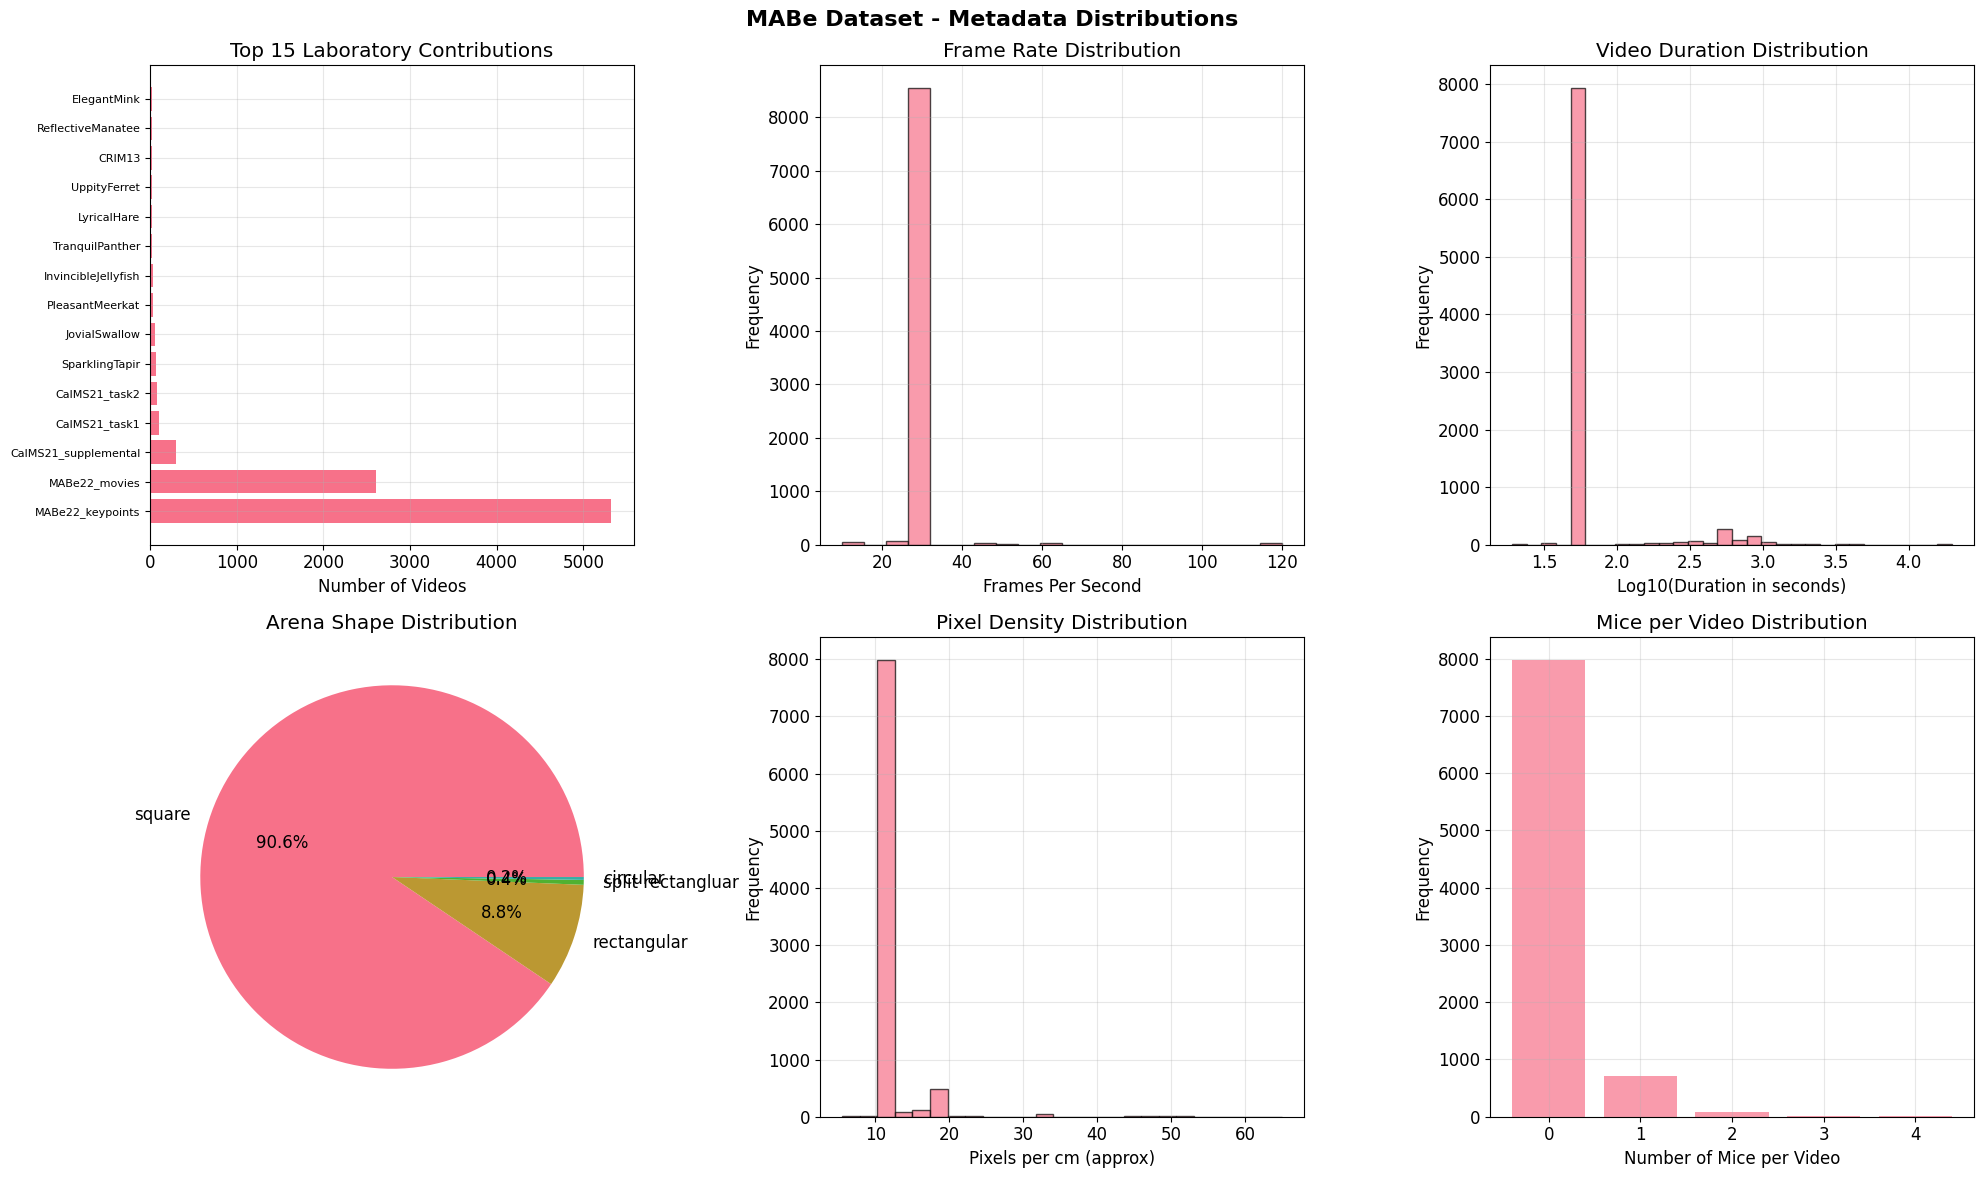

🎯 TRACKING DATA ANALYSIS
----------------------------------------

📊 Analyzing /kaggle/input/MABe-mouse-behavior-detection/train_tracking_CRIM13:
   Shape: (232694, 5)
   Frames: 16621
   Mice: 2
   Body parts: 7 (ear_left, ear_right, hip_left, hip_right, neck...)
   Missing coordinates: 0/232694 (0.0%)
   X range: 0 - 639
   Y range: 78 - 479
   Velocity stats: median=2.8 pix/frame, 95th percentile=38.8
   ⚠️  High velocity events: 2806 (potential tracking errors)

📊 Analyzing /kaggle/input/MABe-mouse-behavior-detection/train_tracking_DeliriousFly:
   Shape: (864128, 5)
   Frames: 54008
   Mice: 2
   Body parts: 8 (body_center, ear_left, ear_right, lateral_left, lateral_right...)
   Missing coordinates: 0/864128 (0.0%)
   X range: 1 - 865
   Y range: 0 - 415
   Velocity stats: median=0.8 pix/frame, 95th percentile=8.5
   ⚠️  High velocity events: 10998 (potential tracking errors)

📊 Analyzing /kaggle/input/MABe-mouse-behavior-detection/train_tracking_UppityFerret:
   Shape: (419944, 5

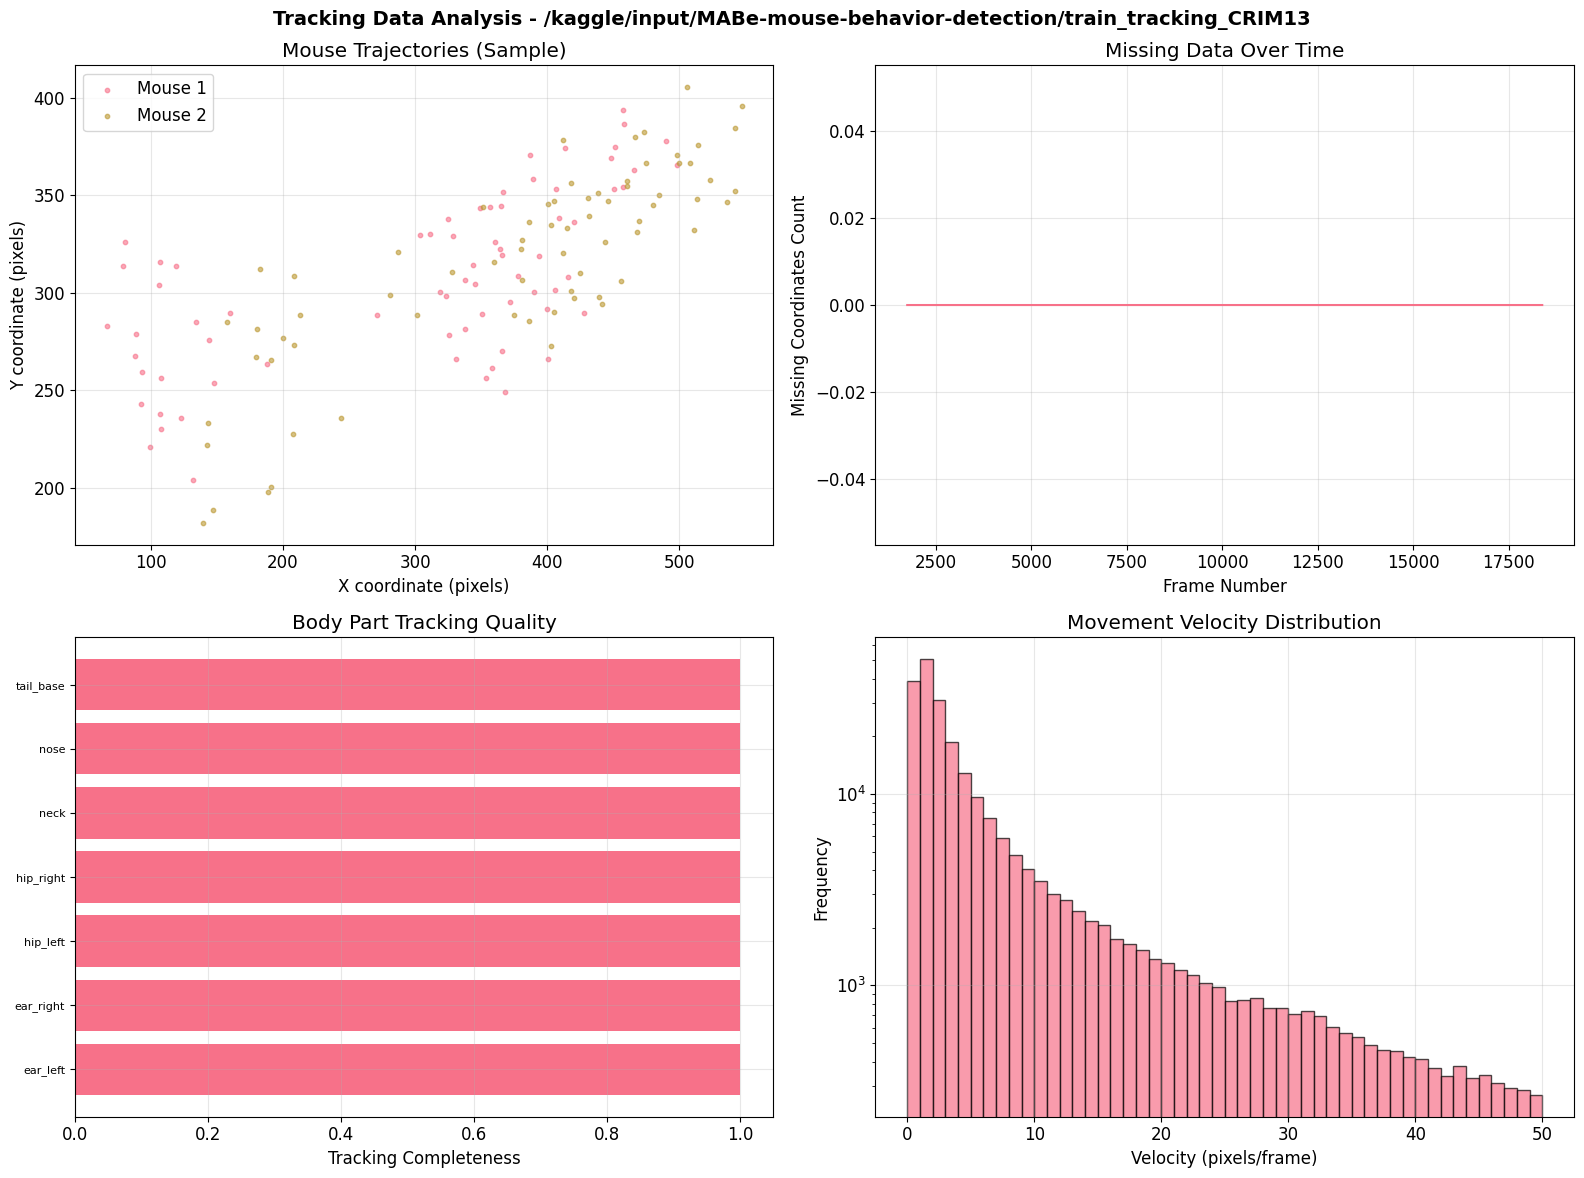


🎭 BEHAVIORAL ANNOTATION ANALYSIS
----------------------------------------

📝 Analyzing CRIM13 annotations:
   Total annotations: 1792
   Unique behaviors: 7
   Most common: sniff, approach, disengage
   Duration range: 0 - 1964 frames
   Median duration: 31 frames
   Self-directed: 435 (24.3%)
   Social interactions: 1357 (75.7%)
   Total annotated frames: 96,865

📝 Analyzing DeliriousFly annotations:
   Total annotations: 811
   Unique behaviors: 3
   Most common: sniff, dominance, attack
   Duration range: 1 - 1883 frames
   Median duration: 48 frames
   Self-directed: 0 (0.0%)
   Social interactions: 811 (100.0%)
   Total annotated frames: 70,498

📝 Analyzing UppityFerret annotations:
   Total annotations: 2161
   Unique behaviors: 3
   Most common: sniffgenital, reciprocalsniff, huddle
   Duration range: 2 - 1371 frames
   Median duration: 14 frames
   Self-directed: 299 (13.8%)
   Social interactions: 1862 (86.2%)
   Total annotated frames: 81,476

🔄 CROSS-LABORATORY ANALYSIS:
  

In [3]:
# 3️⃣ Load the dataset (or generate mock data if files not present)
eda.load_data()

# 4️⃣ Run metadata analysis
eda.analyze_metadata_distribution()

# 5️⃣ Analyze tracking data quality and patterns
eda.analyze_tracking_data()

# 6️⃣ Analyze behavioral annotation patterns
eda.analyze_behavioral_annotations()

# 7️⃣ Check for data quality issues
eda.analyze_data_quality_issues()

# 8️⃣ Analyze cross-laboratory patterns
eda.analyze_cross_laboratory_patterns()